In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params
from lsst.all_sky_phot.star_catalog import read_simbad
from astropy.io import fits
from astropy import wcs
from astropy.wcs import Sip
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture, CircularAnnulus, aperture_photometry

from scipy.spatial import KDTree
import healpy as hp
from lsst.sims.utils import healbin, angularSeparation

from scipy.stats import iqr, binned_statistic
from lsst.sims.utils import healbin

In [2]:
# read in the file that has manual locations of stars
names = ['star_name', 'x', 'y', 'filename']
types = ['|U10', float, float, '|U30']
rough_positions = np.loadtxt('star_coords.dat', dtype=list(zip(names, types)), skiprows=1)

In [3]:
# figure out what MJD each file was taken at
ufiles, files_inverse = np.unique(rough_positions['filename'], return_inverse=True)
mjds = []
# UT offset for Arizona
utc_offset = 7/24. # in days.
for filename in ufiles:
    hdu1 = fits.open('2018-01-26/'+filename)
    # This says UT, but I think it's AZ time
    date_string = hdu1[0].header['DATE-OBS']
    time_obj = Time(date_string, scale='utc')
    mjds.append(time_obj.mjd+utc_offset)
    hdu1.close()

In [4]:
# grab the location from the header
hdu1 = fits.open('2018-01-26/'+ufiles[0])
lat = Latitude(hdu1[0].header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(hdu1[0].header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)
hdu1.close()

In [5]:
all_mjds = [mjds[i] for i in files_inverse]
coords = star2altaz(rough_positions['star_name'], all_mjds, location=PI_backyard)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/units/quantity.py:1000: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return super(Quantity, self).__eq__(other)


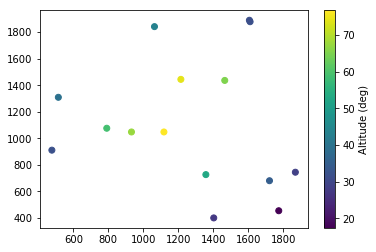

In [6]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['alt'])
cb = plt.colorbar()
cb.set_label('Altitude (deg)')

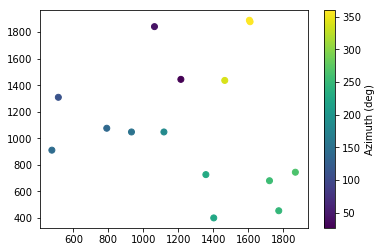

In [7]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['az'])
cb= plt.colorbar()
cb.set_label('Azimuth (deg)')

In [8]:
fun = wcs_zea(rough_positions['x'], rough_positions['y'], coords['alt'], coords['az'],
              crpix1=1202, crpix2=1214)
# Man, figuring out good initial guess for this is a pain in the ass...
x0 = np.array([1200, 1200,  0.5,0.5, 0.1, -0.06,  0.07,   0.1])
fit_result = minimize(fun, x0)
fit_result.x

array([  1.20047959e+03,   1.21568118e+03,   3.33474619e-01,
         3.81628854e-01,   1.83022675e-01,  -1.08992988e-01,
         9.44607249e-02,   1.59506838e-01])

In [9]:
# Convert the fit to a full WCS object
wcs_initial = fun.return_wcs(fit_result.x)

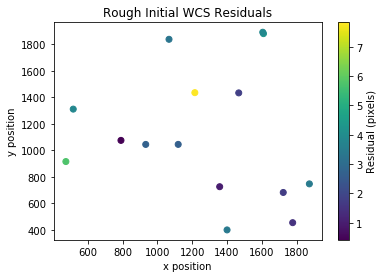

In [10]:
# Check the residuals
fit_x, fit_y = wcs_initial.all_world2pix(coords['az'], coords['alt'], 0)
resid_d = ((fit_x-rough_positions['x'])**2+(fit_y-rough_positions['y'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')

In [11]:
# Read in a catalog of bright stars from Simbad, make sure they are isolated within 20 arcmin
bsc = read_simbad(isolate_catalog=True, isolate_radius=20.)

In [12]:
# load up a dark time L3 image
filename = '2018-02-05/2018_02_05__21_25_15.fits'
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [13]:
# Set photometry paramters
phot_params = default_phot_params()
phot_params['dao_fwhm'] = 2.0
phot_params['dao_thresh'] = 8.
# Measure peaks in the image
phot_table = phot_image(image, phot_params=phot_params)

In [14]:
phot_appertures = CircularAperture( (phot_table['xcenter'], phot_table['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_table['residual_aperture_sum'].data) - zp

In [15]:
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(bsc['RA'], bsc['dec'], mjd, location=PI_backyard)
above = np.where(alt_cat > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

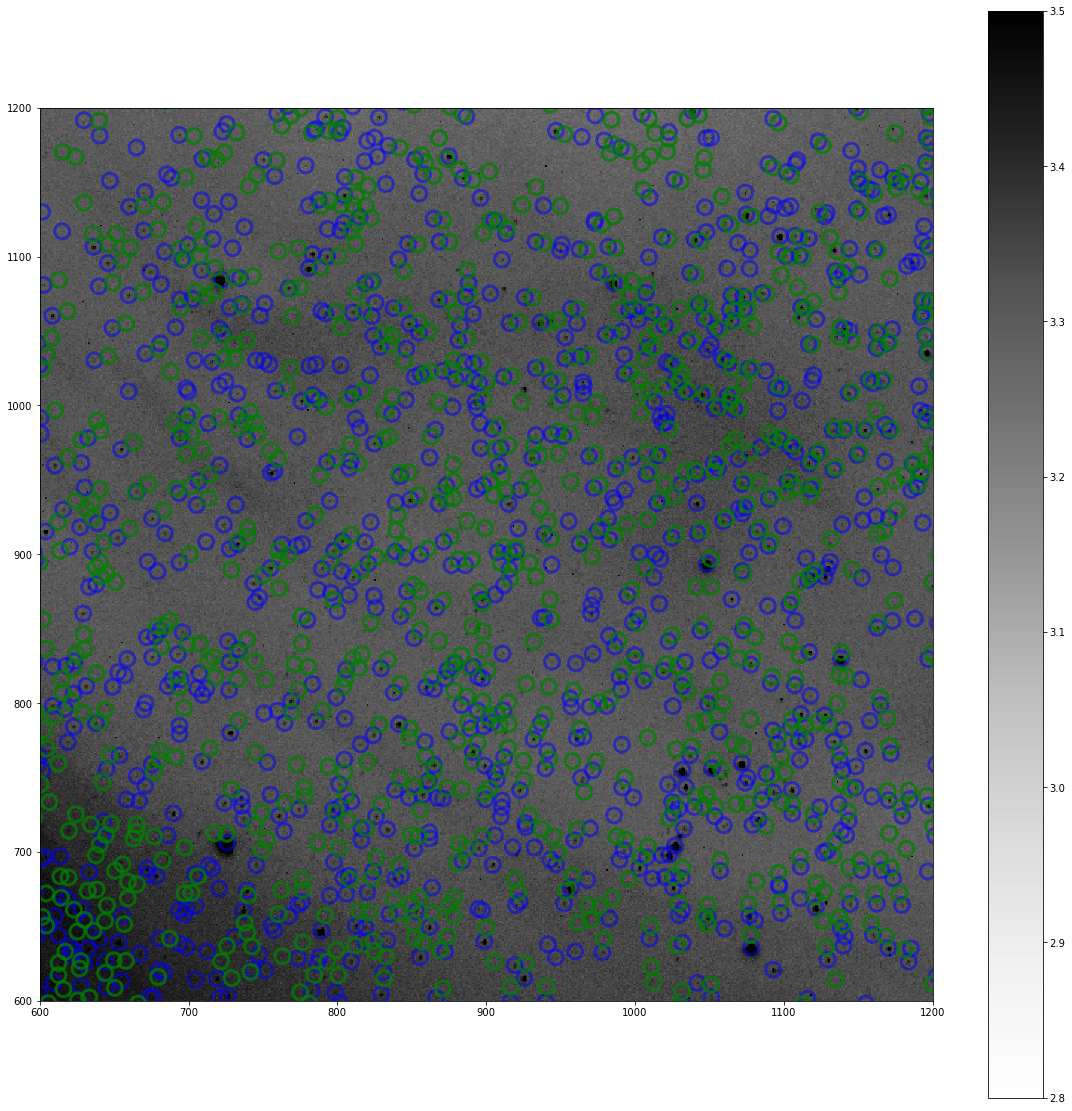

In [16]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
plt.xlim([600, 1200])
plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [17]:
# Let's set some thresholds 
good_cat = np.where((alt_cat > 15.) & (bsc['Vmag'] < 5.5))
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

good_phot = np.where(measured_mags < 9.5)
phot_appertures = CircularAperture( (phot_table['xcenter'][good_phot], phot_table['ycenter'][good_phot]), r=5.)


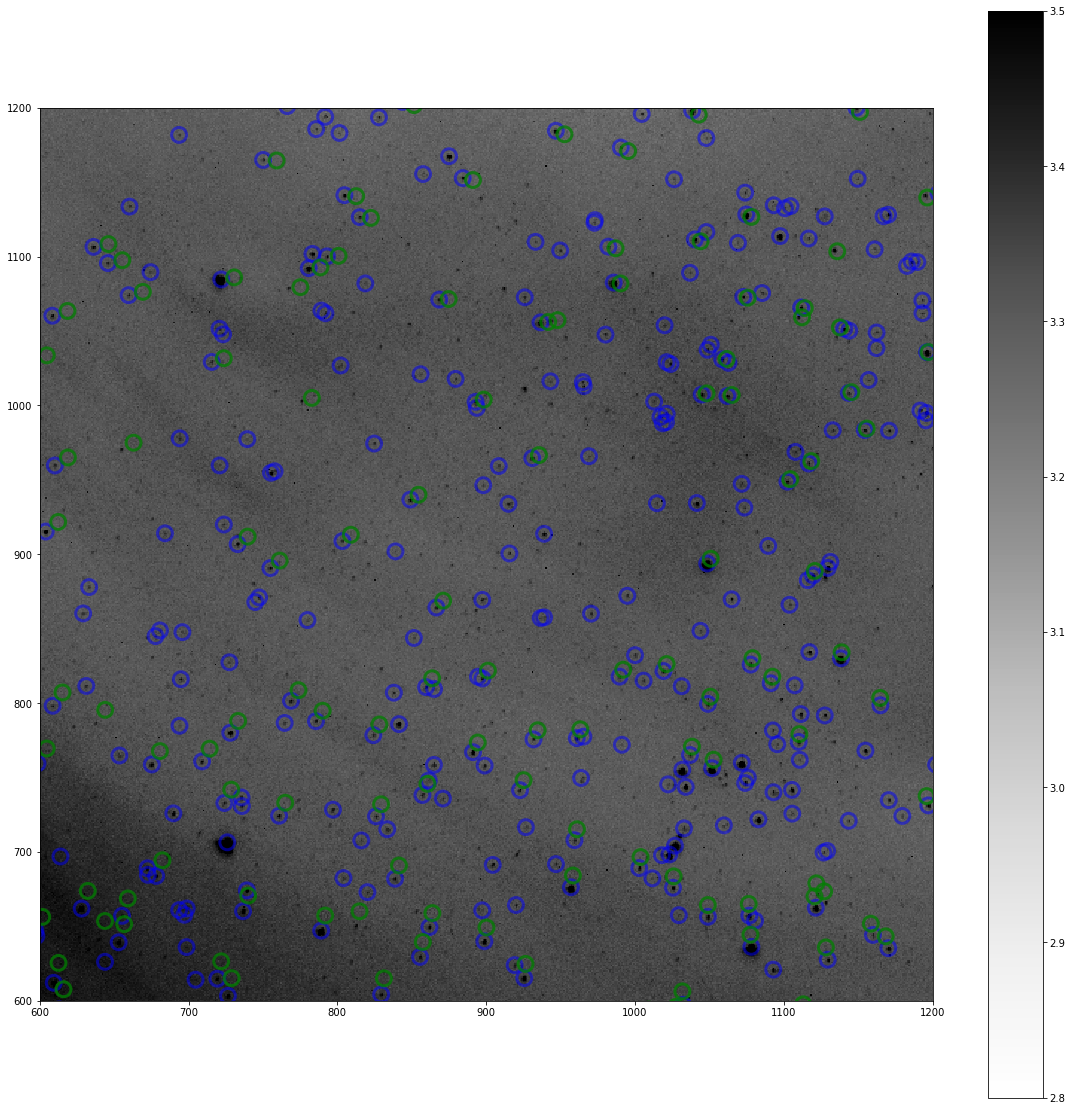

In [18]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
plt.xlim([600, 1200])
plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

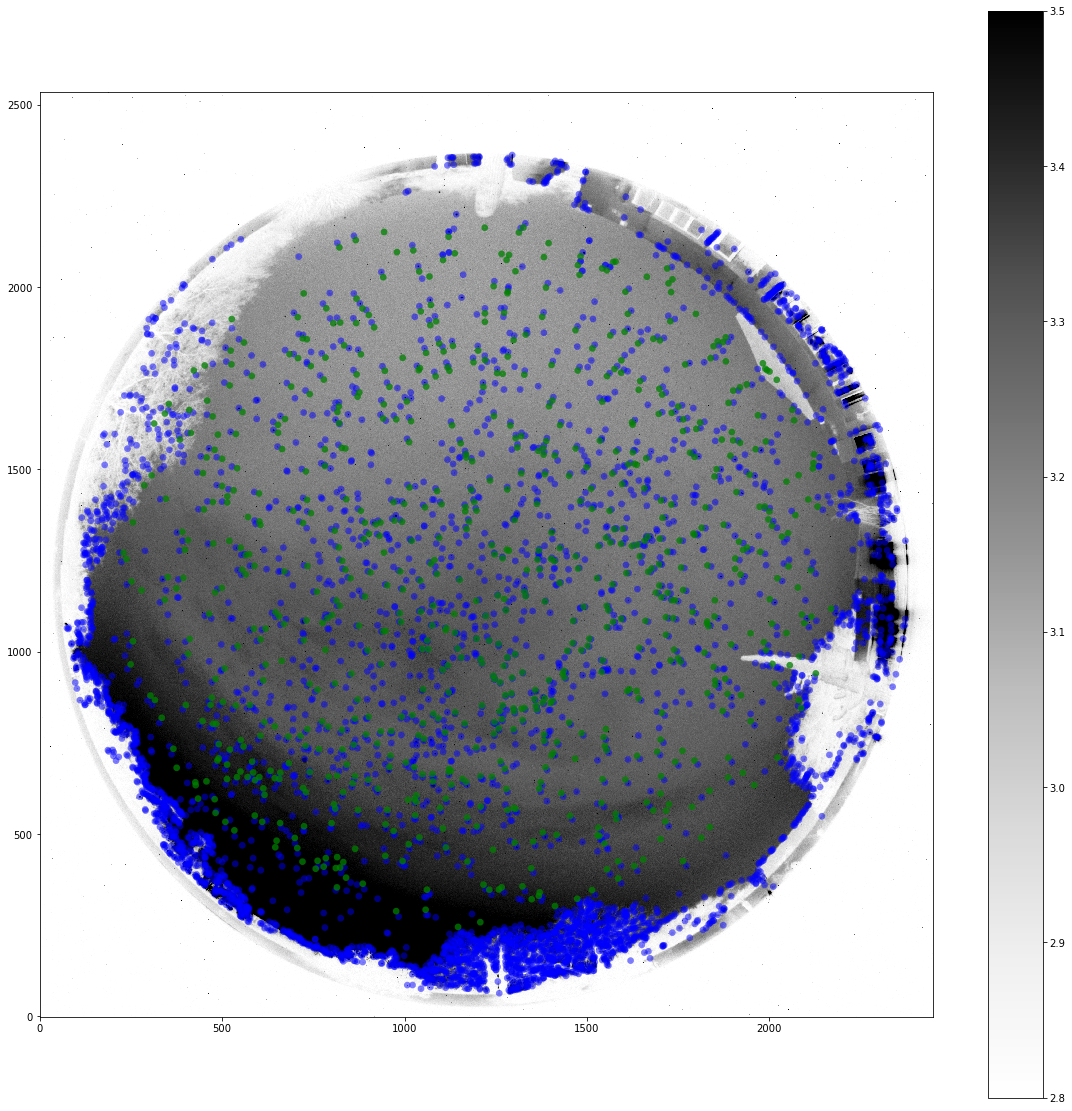

In [19]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
#plt.xlim([600, 1200])
#plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [20]:
class star2detect_wcs_fit(object):
    def __init__(self, detectx, detecty, star_alt, star_az, wcs_in,
                a_order=2, b_order=2, nparams=8):
        """Wrapper to project stars to x,y plane using WCS and compute median distance to nearest neighbor.
        """
        self.star_az = star_az
        self.star_alt = star_alt
        self.w = wcs_in
        self.tree = KDTree(list(zip(detectx, detecty)))
        self.nparams = nparams
        
        self.a_order = a_order
        self.b_order = b_order
        n_a = int((a_order + 1.)**2)
        n_b = int((b_order + 1)**2)

        self.a_ind = np.arange(n_a) + nparams
        self.b_ind = np.arange(n_b) + self.a_ind.max() + 1

        self.sip_zeros_a = np.zeros((a_order+1, a_order + 1))
        self.sip_zeros_b = np.zeros((b_order+1, b_order + 1))
        if self.w.sip is None:
            self.w.sip = wcs.Sip(self.sip_zeros_a, self.sip_zeros_b, self.sip_zeros_a,
                                 self.sip_zeros_b, self.w.wcs.crpix)
        self.w.sip = None
        
        
    def set_wcs(self, x0):
        """
        x0 = [0:crpix1, 1:crpix2, 2:cdelt1, 3:cdelt2, 4:pc, 5:pc, 6:pc, 7:pc, sip... ]
        """
        # Referece Pixel
        self.w.wcs.crpix = [x0[0], x0[1]]

        # Set the cdelt values
        self.w.wcs.cdelt = [x0[2], x0[3]]

        # Set the pc matrix
        self.w.wcs.pc = x0[4:8].reshape((2, 2))

        # Make a new SIP
        if np.size(x0) > self.nparams:
            a = x0[self.a_ind].reshape((self.a_order + 1, self.a_order + 1))
            b = x0[self.b_ind].reshape((self.b_order + 1, self.b_order + 1))
            self.w.sip = Sip(a, b, self.sip_zeros_a, self.sip_zeros_b, self.w.wcs.crpix)
                           
    def return_wcs(self, x0):
        """
        """
        self.set_wcs(x0)
        return self.w
    
    def wcs2x0(self, wcs):
        """
        decompose a wcs object back into a single vector
        """
        if wcs.sip is None:
            max_size = 8
        else:
            max_size = self.b_ind.max()+1

        x0 = np.zeros(max_size)
        x0[0] = wcs.wcs.crpix[0]
        x0[1] = wcs.wcs.crpix[1]
        x0[2] = wcs.wcs.cdelt[0]
        x0[3] = wcs.wcs.cdelt[1]
        x0[4:8] = wcs.wcs.pc.reshape(4)
        if wcs.sip is not None:
            x0[self.a_ind] = wcs.sip.a.reshape((self.a_order+1)**2)
            x0[self.b_ind] = wcs.sip.b.reshape((self.b_order+1)**2)
        return x0
        
    def __call__(self, x, all_dist=False):
        # Make a wcs based on the new x
        self.set_wcs(x)
        
        # Project with the new WCS
        cat_x, cat_y = self.w.all_world2pix(self.star_az, self.star_alt, 0.)
        # Calculate the nearest neighbor for every star in the catalog
        dists, indxs = self.tree.query(list(zip(cat_x, cat_y)))
        
        if all_dist:
            return dists
        else:
            # XXX I think minimizing the median is unstable. Should probably do something like 
            # make an image and put a 2-d gaussian at each star position, then cross-correlate with
            # an image of the catalog star positions. 
            return np.median(dists)
        

In [21]:
func = star2detect_wcs_fit(phot_table['xcenter'][good_phot].value, phot_table['ycenter'][good_phot].value,
                           alt_cat[good_cat], az_cat[good_cat],  wcs_initial)

11.1496269111


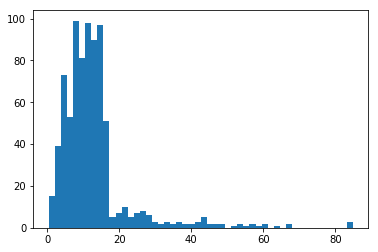

In [22]:
x0 = func.wcs2x0(wcs_initial)
ack = plt.hist(func(x0, all_dist=True), bins=50)
print(func(x0))

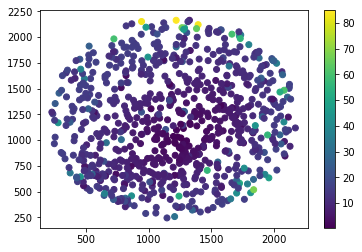

In [23]:
plt.scatter(x_expected, y_expected, c=func(x0, all_dist=True))
cb = plt.colorbar()

In [24]:
new_wcs_x = minimize(func, x0)

In [25]:
new_wcs_x.x, x0

(array([  1.19991759e+03,   1.21611877e+03,   3.12780369e-01,
          3.99741456e-01,   1.91565201e-01,  -1.14094181e-01,
          8.83916561e-02,   1.49577581e-01]),
 array([  1.20047959e+03,   1.21568118e+03,   3.33474619e-01,
          3.81628854e-01,   1.83022675e-01,  -1.08992988e-01,
          9.44607249e-02,   1.59506838e-01]))

3.10409221129


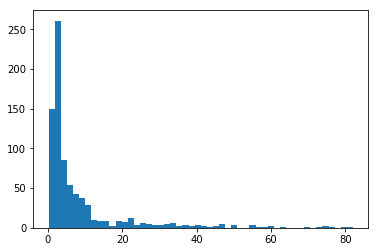

In [26]:
# Shit, is this not replicating exactly? Does the default minimize method actually have a random number in it? Or a precision issue?
ack = plt.hist(func(new_wcs_x.x, all_dist=True), bins=50)
print(func(new_wcs_x.x))

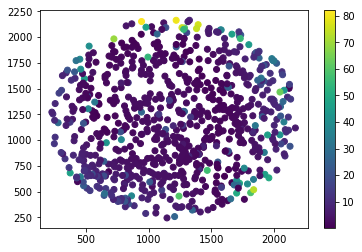

In [27]:
plt.scatter(x_expected, y_expected, c=func(new_wcs_x.x, all_dist=True))
cb = plt.colorbar()

In [28]:
new_wcs = func.return_wcs(new_wcs_x.x)

In [29]:
# Let's set some thresholds 
good_cat = np.where((alt_cat > 15.) & (bsc['Vmag'] < 5.5))
x_expected, y_expected = new_wcs.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

good_phot = np.where(measured_mags < 9.5)
phot_appertures = CircularAperture( (phot_table['xcenter'][good_phot], phot_table['ycenter'][good_phot]), r=5.)


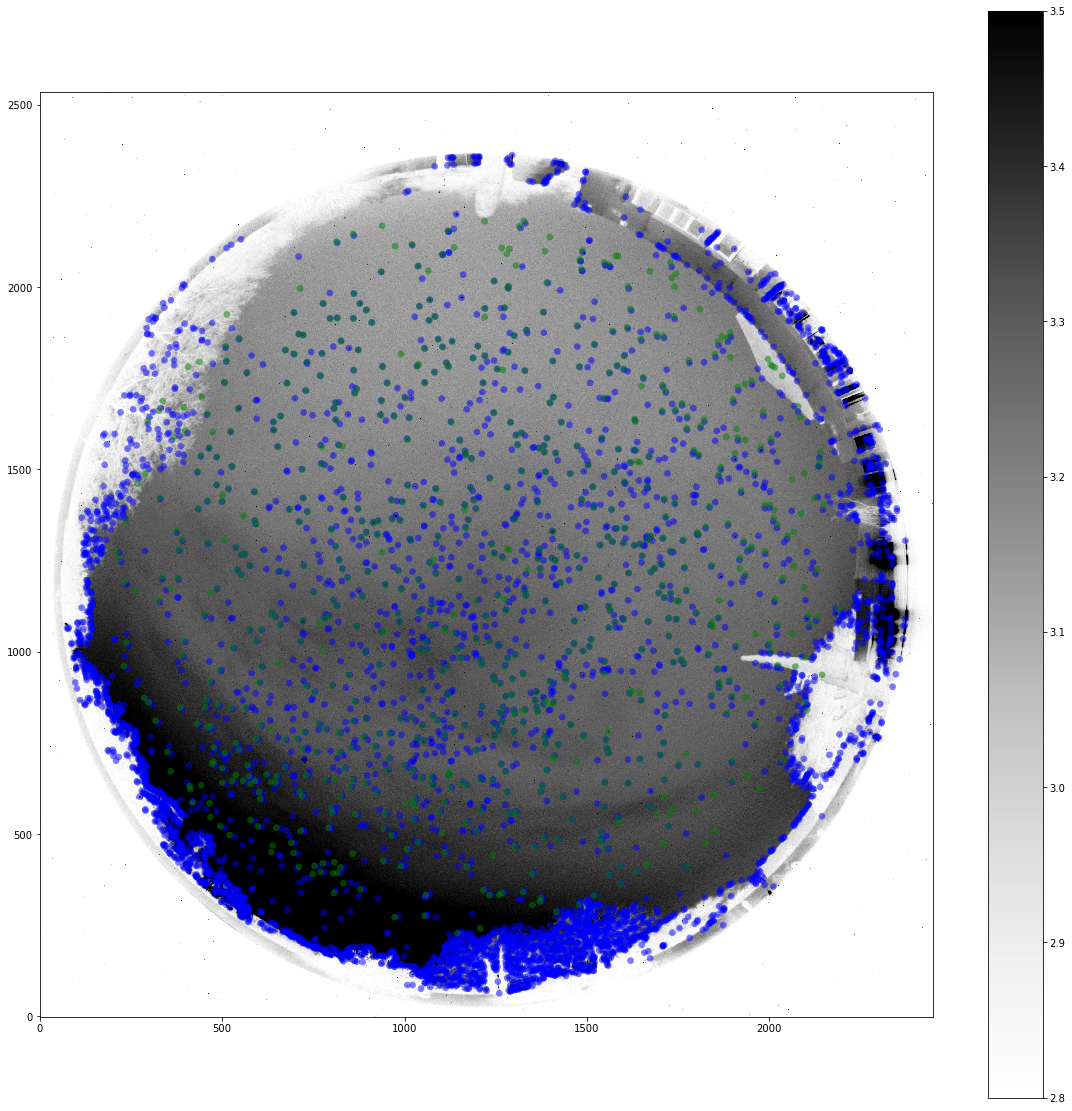

In [30]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
#plt.xlim([600, 1200])
#plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.5)

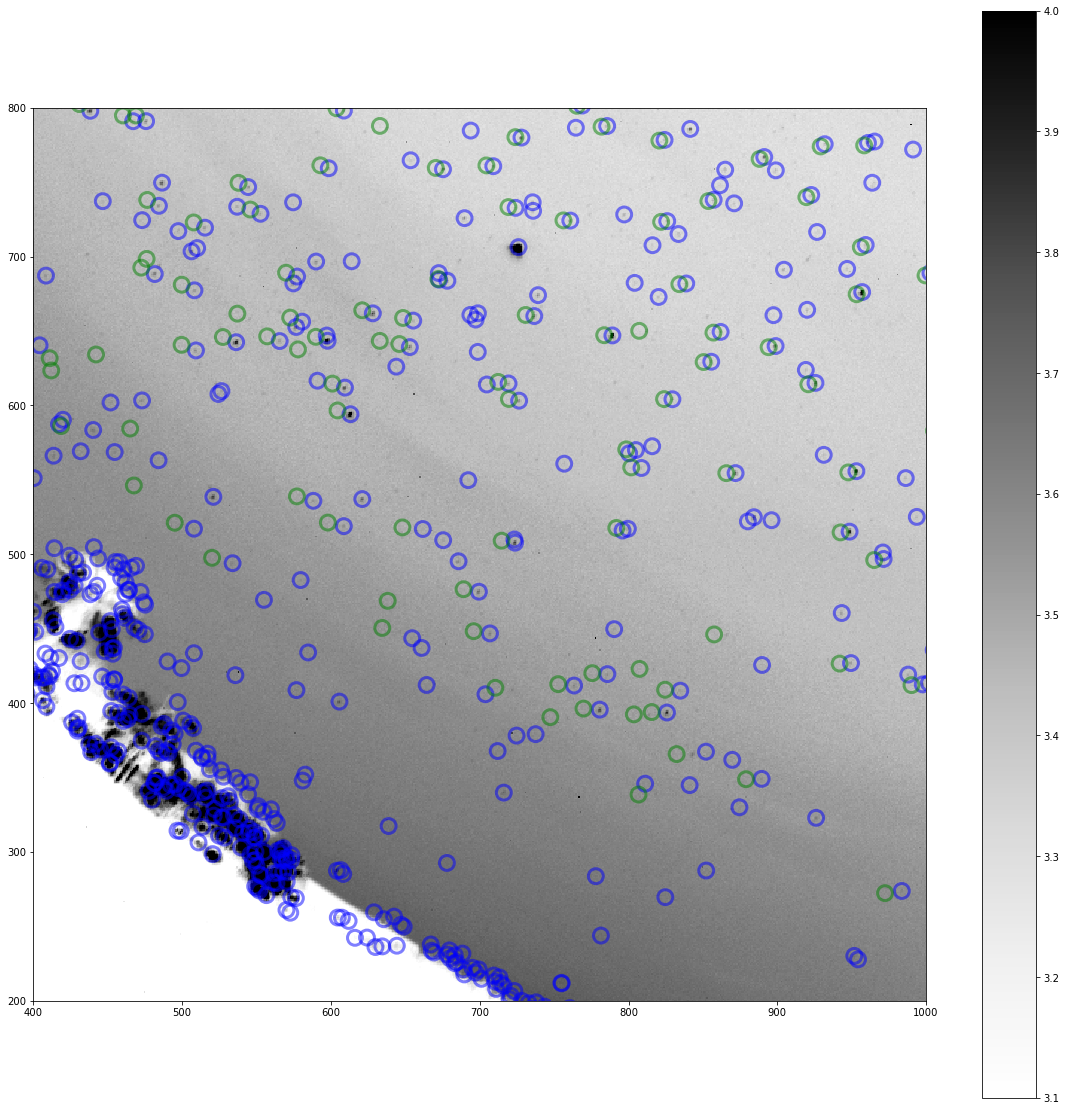

In [31]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=3.1, vmax=4.0)
plt.colorbar()
plt.xlim([400, 1000])
plt.ylim([200,800])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.5)

In [32]:
# OK, now I think we can crank up to more stars, and run the distortion mapper. 
# This might be a nice time to try out doing some SIP coeff again?

In [33]:
wcs_w_shift, result = distortion_mapper_looper(phot_table['xcenter'][good_phot].value, 
                                               phot_table['ycenter'][good_phot].value,
                                               phot_table['ycenter'][good_phot].value*0+1.,
                                               alt_cat[good_cat], 
                                               az_cat[good_cat],
                                               az_cat[good_cat]*0.+1,
                                               new_wcs, xmax=2500, ymax=2500)
                                               

progress = 100.00%

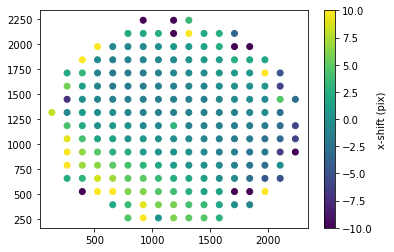

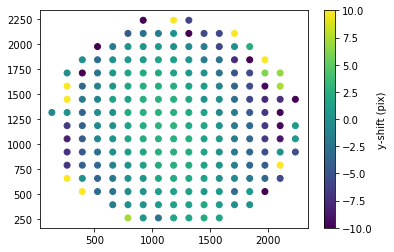

In [34]:
# Let's look at the distortion map
plt.scatter(result['xp'], result['yp'], c=result['xshifts'], vmin=-10, vmax=10)
cb=plt.colorbar()
cb.set_label('x-shift (pix)')
plt.figure()
plt.scatter(result['xp'], result['yp'], c=result['yshifts'], vmin=-10, vmax=10)
cb = plt.colorbar()
cb.set_label('y-shift (pix)')

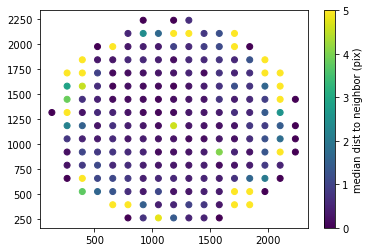

In [35]:
plt.scatter(result['xp'], result['yp'], c=result['distances'], vmax=5)
cb = plt.colorbar()
cb.set_label('median dist to neighbor (pix)')

In [36]:
# Let's set some thresholds 
good_cat = np.where((alt_cat > 15.) & (bsc['Vmag'] < 5.5))
x_expected, y_expected = wcs_w_shift.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

good_phot = np.where(measured_mags < 9.5)
phot_appertures = CircularAperture( (phot_table['xcenter'][good_phot], phot_table['ycenter'][good_phot]), r=5.)


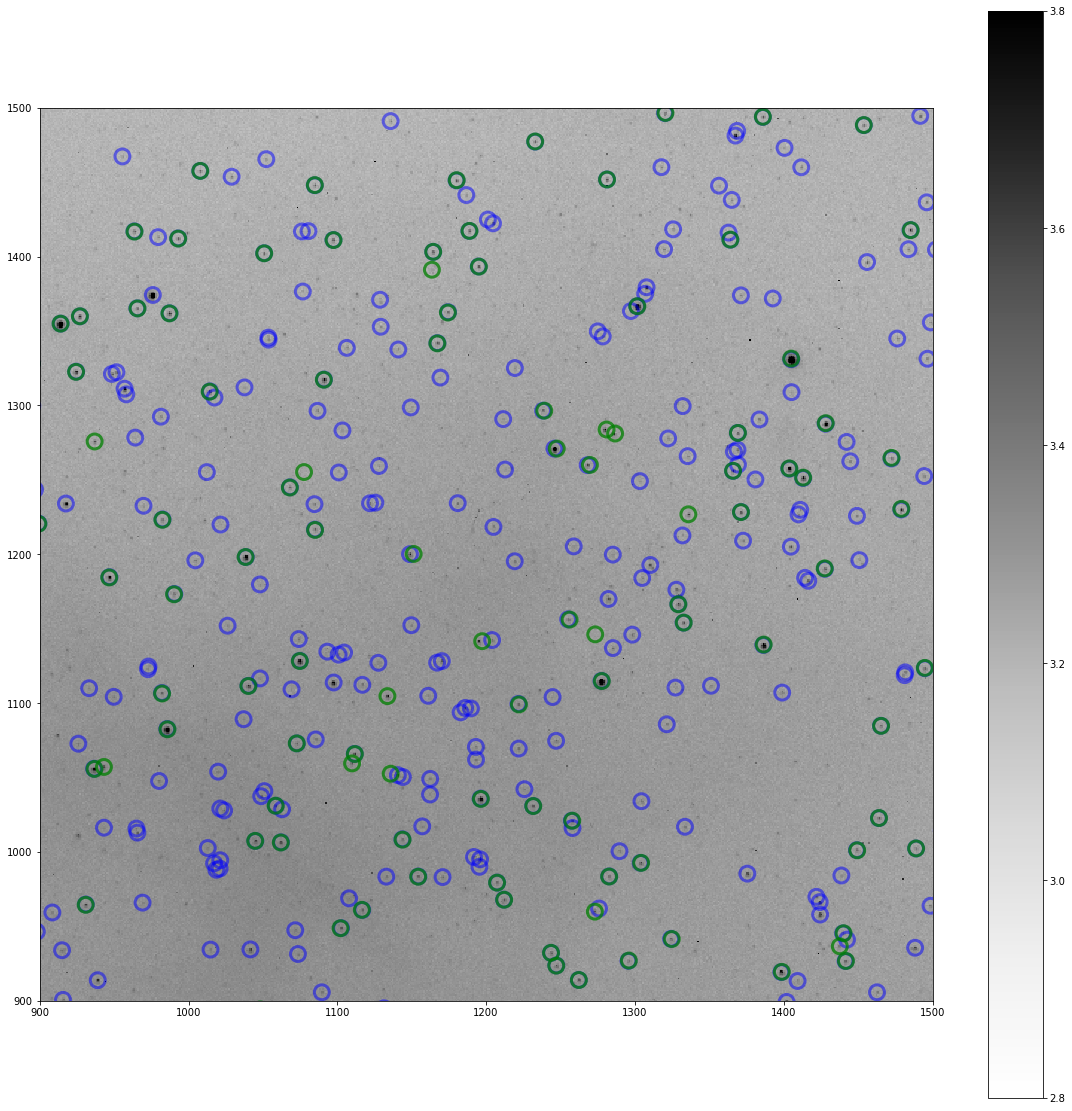

In [37]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.8)
plt.colorbar()
plt.xlim([900, 1500])
plt.ylim([900,1500])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

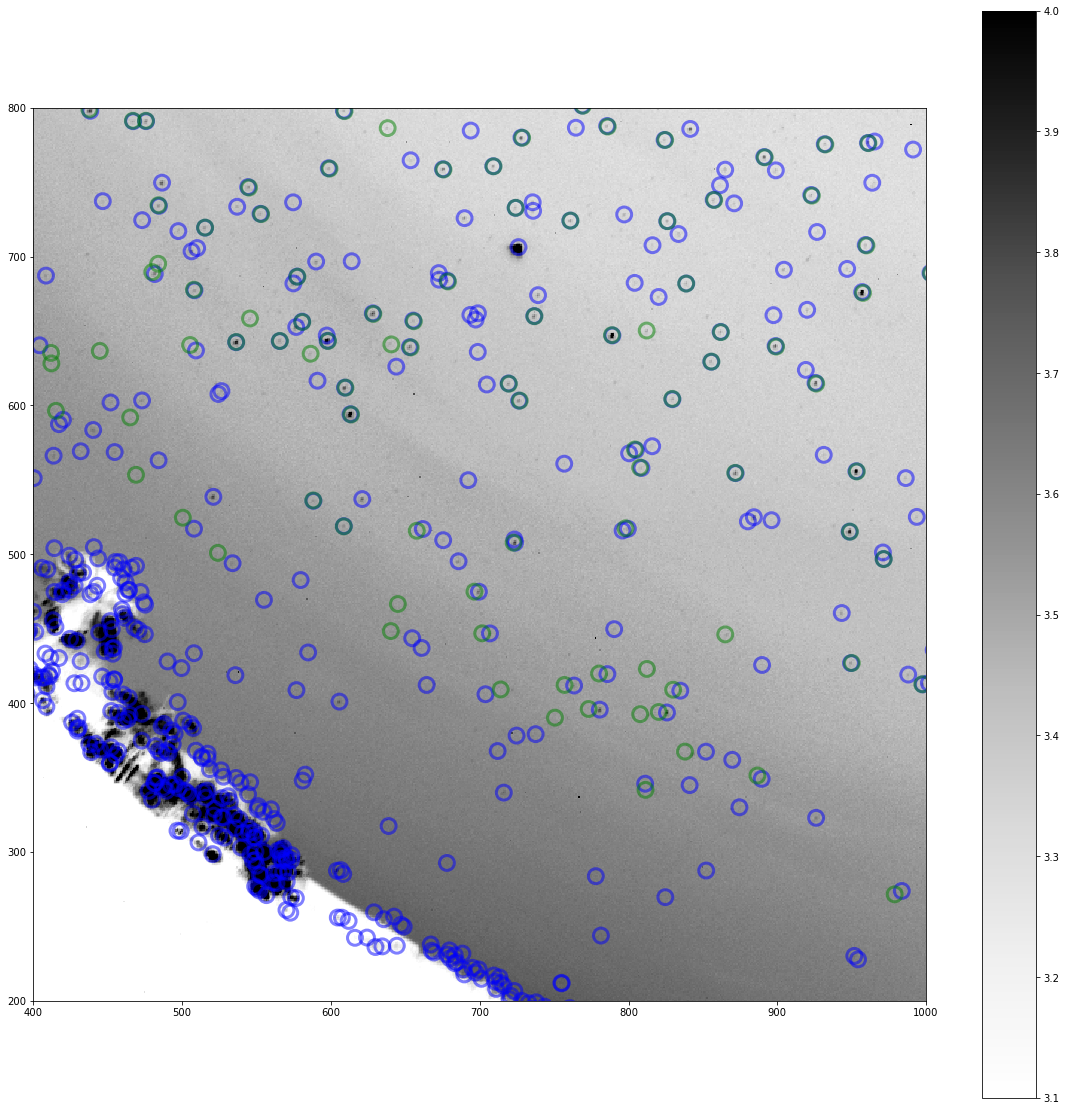

In [38]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=3.1, vmax=4.0)
plt.colorbar()
plt.xlim([400, 1000])
plt.ylim([200,800])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.5)

In [39]:
# I should do a pass to make the catalog isolated. 
# crank up to avoid some nans
good_cat = np.where((alt_cat > 18.1) & (bsc['Vmag'] < 7.5) & (bsc['Vmag'] > 1.))
x_expected, y_expected = wcs_w_shift.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)
annulus_apertures = CircularAnnulus((x_expected, y_expected), r_in=6., r_out=8.)

In [40]:
# might need to do some more background subtraction
forced_table = aperture_photometry(image, [apertures, annulus_apertures])

In [41]:
bkg_mean = forced_table['aperture_sum_1'] / annulus_apertures.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = forced_table['aperture_sum_0'] - bkg_sum
forced_table['residual_aperture_sum'] = final_sum

In [42]:
forced_table

<QTable length=4866>
  id       xcenter       ... aperture_sum_1 residual_aperture_sum
             pix         ...                                     
int64      float64       ...    float64            float64       
----- ------------------ ... -------------- ---------------------
    1  2141.365252496454 ...  162628.342483          6.0287692656
    2  2120.429034788349 ...  161506.076092         65.1170391209
    3 2125.6854052446147 ...  162884.441759        -915.197267826
    4 2134.4993257488345 ...  166048.423162         2177.33743105
    5 2102.3897962841434 ...  157392.956859        -474.614749726
    6  2104.455830828043 ...  157182.581319         2387.51127777
    7  2111.401930819602 ...  158882.681799         618.334825353
    8  2106.024247750588 ...  158300.029519         597.670849721
    9 2088.7617838924016 ...  156508.049976         2649.47446931
  ...                ... ...            ...                   ...
 4857  1047.445979168187 ...  195169.269203         257.037621884
 4858  608.8731483368629 ...  319869.819945        -2558.10880238
 4859  1699.184718818366 ...   188429.40947        -85.1459549324
 4860  698.6955851850673 ...  218850.936731         6261.44360394
 4861  684.1994204946443 ...  266452.914164         519.244822943
 4862 1612.2490192265527 ...  192153.896153        -1092.88714748
 4863   332.657112007873 ...  200379.698742        -11122.9704486
 4864  564.2265593833091 ...  284662.749242         1685.29239052
 4865  739.4117075412639 ...  222255.126848        -823.458069679
 4866  709.2763659359961 ...  183816.281358         5318.81129385

In [43]:
measured_mags = -2.5*np.log10(forced_table['residual_aperture_sum'])

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


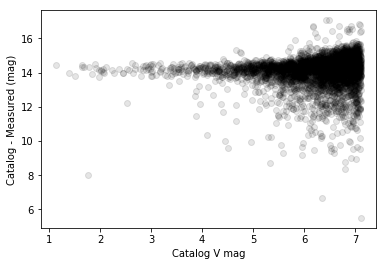

In [44]:
plt.plot(bsc['Vmag'][good_cat], bsc['Vmag'][good_cat]-measured_mags, 'ko', alpha=.1)
plt.xlabel('Catalog V mag')
plt.ylabel('Catalog - Measured (mag)')

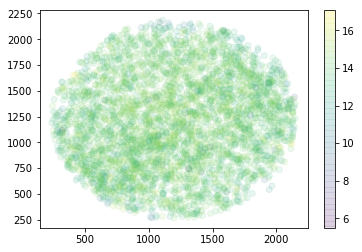

In [45]:
deltam = bsc['Vmag'][good_cat]-measured_mags
plt.scatter(x_expected, y_expected, c=deltam, alpha=.1)
cb = plt.colorbar()

In [46]:
good = np.where((bsc['Vmag'][good_cat] > 3) & (bsc['Vmag'][good_cat] < 4) &(np.isnan(deltam) == False))

In [47]:
iqr(deltam[good], scale='normal'), np.std(deltam[good])

(0.24313637628324453, 0.50343319199608827)

In [48]:
good[0].size, bsc['Vmag'][good_cat].size

(75, 4866)

In [49]:
def iqr_normal(values):
    # Just ignore nans on the way in
    good = np.where(np.isnan(values) == False)
    return iqr(values[good], scale='normal')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


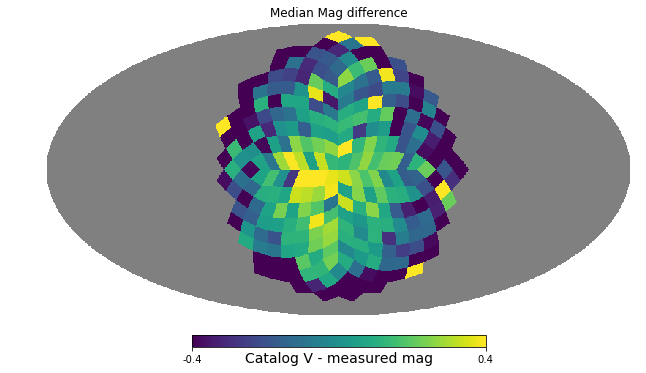

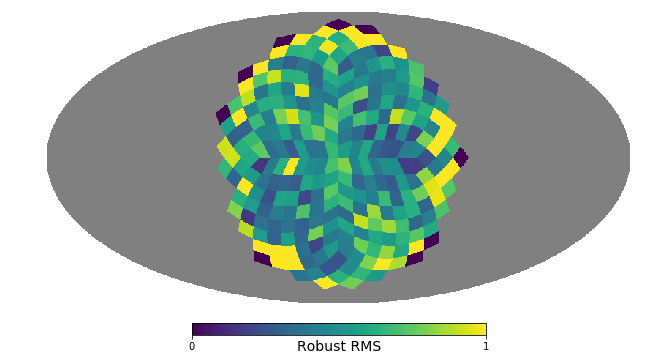

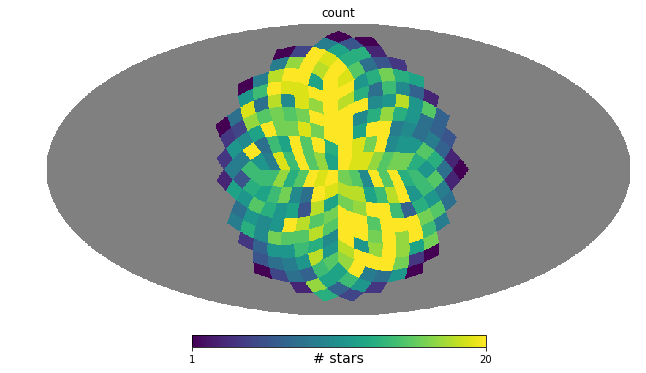

In [50]:
good = np.where(np.isnan(deltam) == False)
nside=8
delta_map = healbin(az_cat[good_cat][good], alt_cat[good_cat][good],
                    deltam[good]-np.median(deltam[good]), nside, reduceFunc=np.median)
iqr_map = healbin(az_cat[good_cat][good], alt_cat[good_cat][good],
                    deltam[good]-np.median(deltam[good]), nside, reduceFunc=iqr_normal)
count_map = healbin(az_cat[good_cat][good], alt_cat[good_cat][good],
                    deltam[good]-np.median(deltam[good]), nside, reduceFunc=np.size)

hp.mollview(delta_map, rot=(0,90,0), min=-.4, max=0.4, title='Median Mag difference', unit='Catalog V - measured mag')
hp.mollview(iqr_map, title='', rot=(0,90,0), max=1, unit='Robust RMS')
hp.mollview(count_map, title='count', rot=(0,90,0), max=20, unit='# stars')


In [51]:
# Should check and see how many nans I get as a function of mag bin.
bins = np.arange(1,7.3, 0.2)
all_stars, bins = np.histogram(bsc['Vmag'][good_cat], bins=bins)
measured_stars, bins = np.histogram(bsc['Vmag'][good_cat][good], bins=bins)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


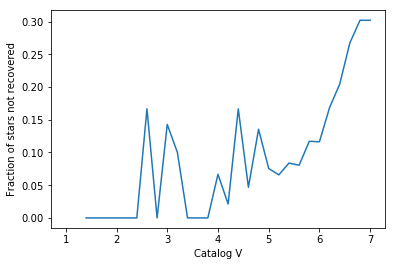

In [52]:
plt.plot(bins[:-1], (all_stars-measured_stars)/all_stars)
plt.xlabel('Catalog V')
plt.ylabel('Fraction of stars not recovered')

In [53]:
# Let's compute the robust RMS in each bin too:
bins = np.arange(1,7.3, 0.2)
rmss, bin_edges, binn = binned_statistic(bsc['Vmag'][good_cat],
                                                     bsc['Vmag'][good_cat]-measured_mags, 
                                                     bins=bins,
                                                    statistic=iqr_normal)
mean_v, bin_edges, binn = binned_statistic(bsc['Vmag'][good_cat],
                                                     bsc['Vmag'][good_cat], 
                                                     bins=bins,
                                                    statistic='mean')

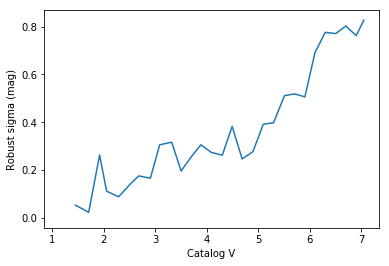

In [54]:
plt.plot(mean_v, rmss)
plt.xlabel('Catalog V')
plt.ylabel('Robust sigma (mag)')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(-4, 4)

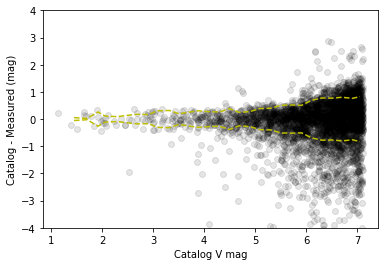

In [55]:
diff = bsc['Vmag'][good_cat]-measured_mags
zp = np.median(diff[np.where(np.isnan(diff) == False)])
plt.plot(bsc['Vmag'][good_cat], bsc['Vmag'][good_cat]-measured_mags-zp, 'ko', alpha=.1)
plt.xlabel('Catalog V mag')
plt.ylabel('Catalog - Measured (mag)')
plt.plot(mean_v, rmss, 'y--')
plt.plot(mean_v, -rmss, 'y--')
plt.ylim([-4,4])

Things to fiddle with:

* I think the local background subtraction is using a mean rather than median. That kinda sucks, especially when crowded.--Ah, there are functions made for wfpc3, coppied over.
* Might want to make an "isolated" condition on the stars. 
* Would be nice to actually fit SIP terms rather than the brute force mapping of distortions.

In [56]:
# Let's check the pixel scale
az1, alt1 = wcs_w_shift.all_pix2world(1200, 1200, 0.)
az2, alt2 = wcs_w_shift.all_pix2world(1201, 1200, 0.)

In [57]:
angularSeparation(az1, alt1, az2, alt2)*60

4.3136186759633555

In [58]:
bsc['RA']

masked_array(data = [315.3036025416666 319.75015849999994 319.8325708333333 ...,
 350.20907083333327 289.41650416666664 302.7809708333333],
             mask = [False False False ..., False False False],
       fill_value = 1e+20)

In [59]:
# Read in a catalog of bright stars from Simbad
bsc = read_simbad()

In [60]:
bcs_iso = read_simbad(isolate_catalog=True, isolate_radius=20.)

In [61]:
bcs_iso.size, bsc.size

(13765, 18403)

In [64]:
wcs_w_shift.save('L3_wcs_w_shift')